In [1]:
import torch
from torchvision import transforms, models, datasets
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.ion() 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

train_on_gpu = False


In [2]:
# Resize input image 
def resize_image(input_image_path,size):
    original_image = Image.open(input_image_path)
    resized_image = original_image.resize(size)
    resized_image.show()


In [3]:
# The path of our dataset
dataset = "dataset"

In [4]:
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
test_size = 0.3


# TODO: Define your transforms for the training and validation sets

mydata_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



# TODO: Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(dataset,transform=mydata_transforms)

# split the data into training - test set
n_image = len(image_datasets)
indices = list(range(n_image))
np.random.shuffle(indices)
split = int(np.floor(test_size * n_image))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Using the image datasets and the trainforms, define the dataloaders
traindataloaders = torch.utils.data.DataLoader(image_datasets,batch_size=batch_size,sampler=train_sampler)
testdataloaders  = torch.utils.data.DataLoader(image_datasets,batch_size=batch_size,sampler=test_sampler,)

class_names = image_datasets.classes

In [5]:
print(class_names)

['cat', 'dog']


In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

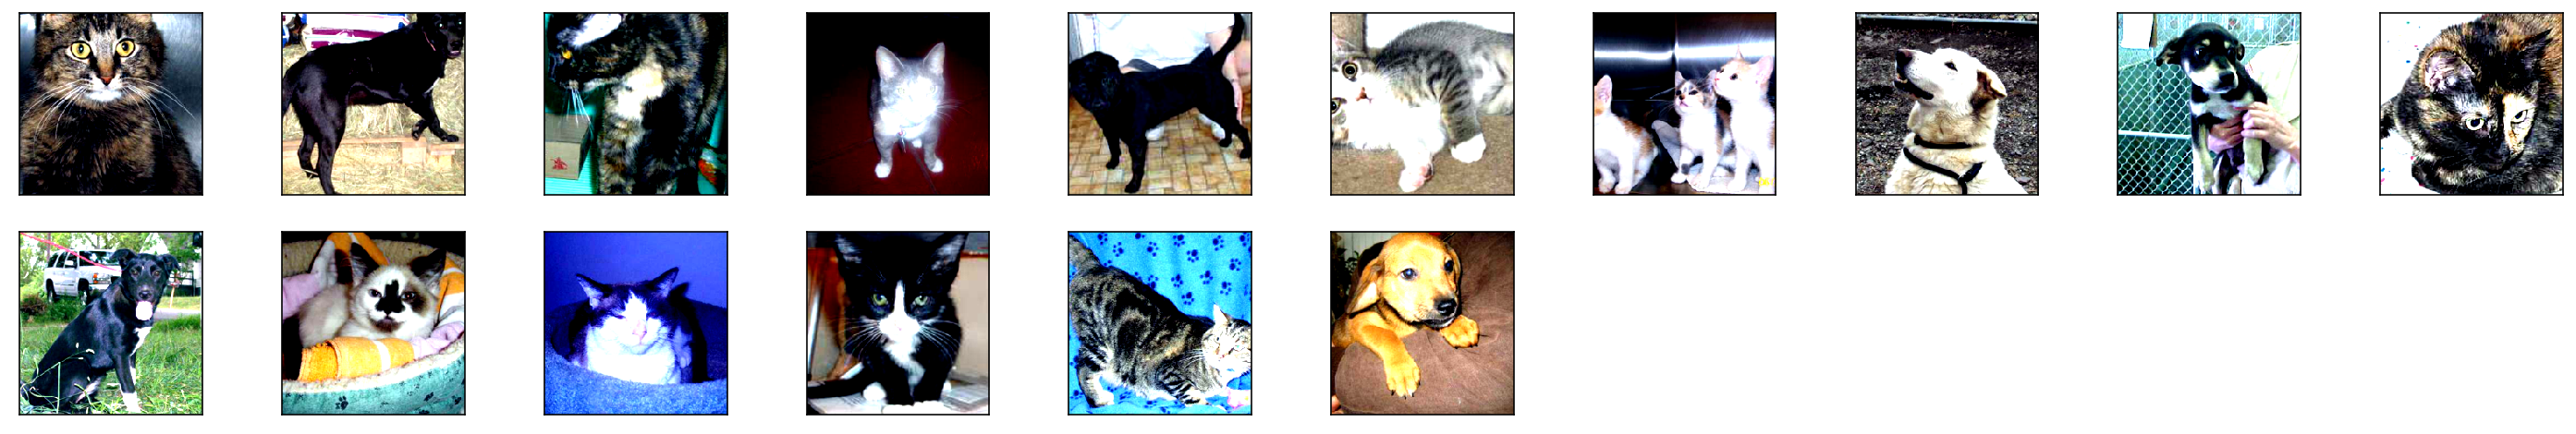

In [8]:
# obtain one batch of training images
dataiter = iter(traindataloaders)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 32, 7)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32 * 52*52, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 52 * 52)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

model = CNNModel()
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)


In [9]:
if train_on_gpu:
    model.cuda() #.cuda() will move everything to the GPU side
    
    
criterion = nn.CrossEntropyLoss()
criterion_deep = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(traindataloaders)
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        acc_train = 0
        
        model.train(True)
        
        for i, data in enumerate(traindataloaders):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches ), end='', flush=True)
                
                
            inputs, labels = data
            
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            acc_train += torch.mean(equals.type(torch.FloatTensor)).item()
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            

        avg_loss = loss_train  /  len(traindataloaders)
        avg_acc = acc_train  / len(traindataloaders)
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()


    return model

In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
Training batch 0/44

D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training batch 40/44
Epoch 0 result: 
Avg loss (train): 0.6904
Avg acc (train): 0.5365
----------

Epoch 2/10
----------
Training batch 40/44
Epoch 1 result: 
Avg loss (train): 0.6799
Avg acc (train): 0.5814
----------

Epoch 3/10
----------
Training batch 40/44
Epoch 2 result: 
Avg loss (train): 0.6642
Avg acc (train): 0.5791
----------

Epoch 4/10
----------
Training batch 40/44
Epoch 3 result: 
Avg loss (train): 0.6526
Avg acc (train): 0.6151
----------

Epoch 5/10
----------
Training batch 40/44
Epoch 4 result: 
Avg loss (train): 0.6504
Avg acc (train): 0.6416
----------

Epoch 6/10
----------
Training batch 40/44
Epoch 5 result: 
Avg loss (train): 0.6399
Avg acc (train): 0.6444
----------

Epoch 7/10
----------
Training batch 40/44
Epoch 6 result: 
Avg loss (train): 0.6894
Avg acc (train): 0.5876
----------

Epoch 8/10
----------
Training batch 40/44
Epoch 7 result: 
Avg loss (train): 0.6441
Avg acc (train): 0.6534
----------

Epoch 9/10
----------
Training batch 40/44
Epoch 8 res